# An End-to-End Big Data Analytics Framework for E-commerce: Leveraging Apache Spark and CRISP-DM for Consumer Behavior Insights

### Project Plan and Business Questions: 

We have established the foundation to answer these three specific questions:

1.	Customer Segmentation: "How can we categorize our customer base into distinct groups (VIP, At-Risk, New) based on their RFM scores to tailor marketing strategies?"
2.	Product Association: "Which top 5 product pairs are most frequently purchased together, and how can this inform a cross-selling strategy?"
3.	Revenue Trends: "Which geographical regions contribute to 80% of our total revenue, and what are the peak purchasing hours in those regions?"

In [22]:
# Step 2: Installing Python Dependencies
# This cell will install PySpark and other useful libraries into your active virtual environment.
!pip install pyspark pandas openpyxl seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Windows Patch

In [23]:
import sys
import socket

# This fix is required for Spark compatibility with Python 3.12+ on Windows
if sys.platform == "win32":
    import socketserver
    from socketserver import ThreadingMixIn, TCPServer
    socketserver.UnixStreamServer = type('UnixStreamServer', (ThreadingMixIn, TCPServer), {})
    socketserver.UnixDatagramServer = type('UnixDatagramServer', (ThreadingMixIn, TCPServer), {})

#### Initialising the Spark Session and Defining the paths

In [24]:
import os
import sys
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Initialize Spark Session (Keep active for the whole project)
print("Initializing Spark Session...")
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("EcommerceAnalyticsProject") \
    .getOrCreate()

# Define paths (Based on your folder structure)
DATA_DIR = "./Data"
CSV_PATH_1 = os.path.join(DATA_DIR, "retail_data_2009_2010.csv")
CSV_PATH_2 = os.path.join(DATA_DIR, "retail_data_2010_2011.csv")

Initializing Spark Session...


#### Loading and combining the given dataset

In [25]:
# Load and Union Datasets
print("Loading data into Spark DataFrames...")
df1 = spark.read.csv(CSV_PATH_1, header=True, inferSchema=True)
df2 = spark.read.csv(CSV_PATH_2, header=True, inferSchema=True)

# Combine datasets (1.06M rows)
raw_df = df1.unionByName(df2)

Loading data into Spark DataFrames...


### Renaming columns for easier coding

In [26]:
# Rename columns for easier coding
raw_df = raw_df.withColumnRenamed("Customer ID", "CustomerID") \
               .withColumnRenamed("Invoice", "InvoiceNo")

print(f"✅ Total Records Ingested: {raw_df.count():,}")

✅ Total Records Ingested: 1,067,371


In [27]:
# ==========================================
# PHASE 2: DATA UNDERSTANDING & VERIFICATION
# ==========================================
from datetime import datetime

# Calculate core metrics for the report
total_rows = raw_df.count()
unique_customers = raw_df.select("CustomerID").distinct().count()
date_range = raw_df.select(F.min("InvoiceDate"), F.max("InvoiceDate")).collect()

print(f"✅ DATASET SUMMARY")
print(f"----------------------------------------------------------------------------------")
print(f"Total Transaction Records : {total_rows:,}")
print(f"Unique Customer IDs      : {unique_customers:,}")
print(f"Study Period             : {date_range[0][0]} to {date_range[0][1]}")
print(f"----------------------------------------------------------------------------------")

# Display a clean, styled table
print("\n--- SAMPLE DATA PREVIEW ---")
raw_df.limit(5).toPandas()

✅ DATASET SUMMARY
----------------------------------------------------------------------------------
Total Transaction Records : 1,067,371
Unique Customer IDs      : 5,943
Study Period             : 2009-12-01 07:45:00 to 2011-12-09 12:50:00
----------------------------------------------------------------------------------

--- SAMPLE DATA PREVIEW ---


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"""RECORD FRAME 7"""" SINGLE SIZE """,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [28]:
raw_df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



### Data Visualisation

#### Top 10 Countries by Transaction Volume

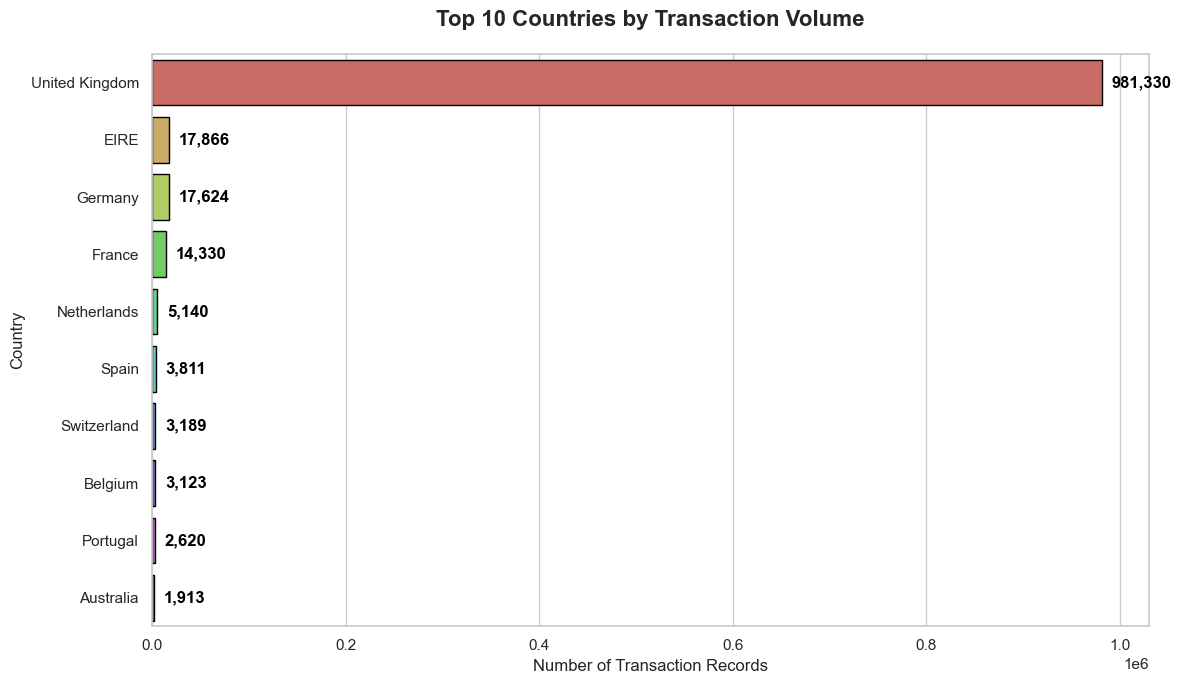

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract top 10 countries
top_countries = raw_df.groupBy("Country").count().orderBy("count", ascending=False).limit(10).toPandas()

# Set the visual style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# FIX: Assigning 'Country' to 'hue' and setting 'legend=False' removes the warning
ax = sns.barplot(
    data=top_countries, 
    x='count', 
    y='Country', 
    hue='Country', 
    palette='hls', 
    legend=False,
    edgecolor='black'
)

# Formatting the Chart
plt.title('Top 10 Countries by Transaction Volume', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Transaction Records', fontsize=12)
plt.ylabel('Country', fontsize=12)

# Adding Data Labels for a "Very Clear Output"
for i, v in enumerate(top_countries['count']):
    ax.text(v + 10000, i, f'{v:,}', color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Observation:

The visualization above utilizes the raw_df to provide a complete overview of the initial 1,067,371 records. This allows us to observe the true distribution of global transactions before the filtering of the 243,007 records with missing CustomerIDs in the cleaning phase.

#### Monthly Transaction Volume (Seasonality)

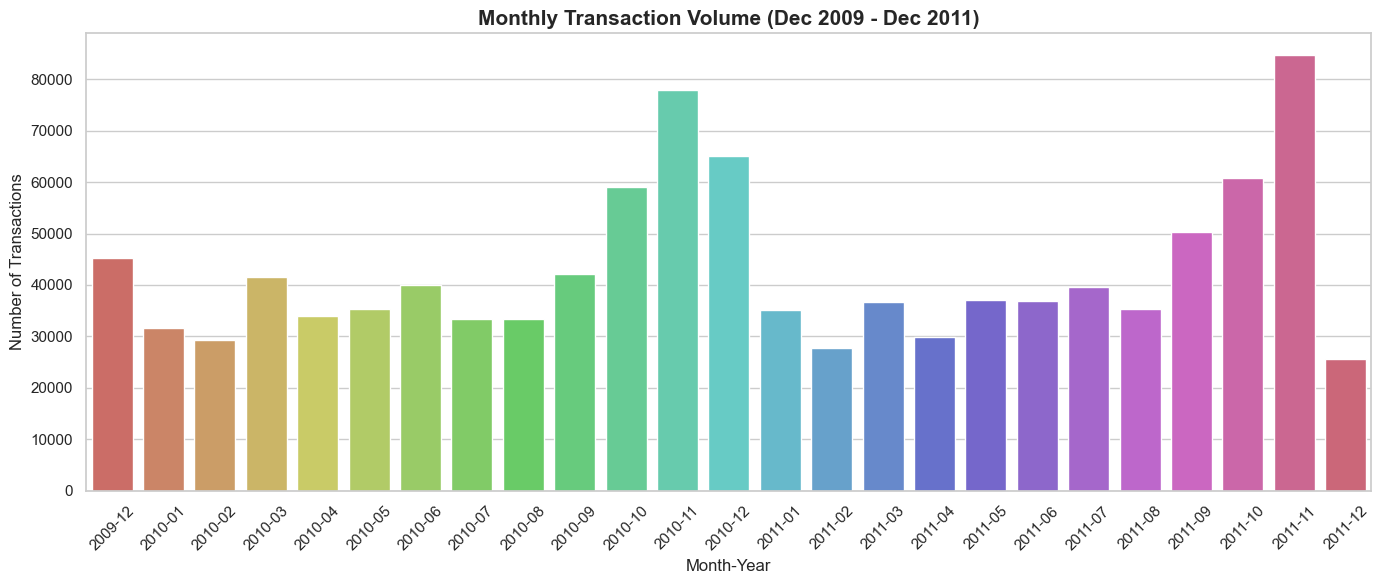

In [30]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data: Extract Month and Year for grouping
monthly_data = raw_df.withColumn("MonthYear", F.date_format("InvoiceDate", "yyyy-MM")) \
                     .groupBy("MonthYear").count() \
                     .orderBy("MonthYear").toPandas()

# 2. Plotting
plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid")

# Using the 'hls' palette for a bright, colorful look
ax = sns.barplot(data=monthly_data, x='MonthYear', y='count', hue='MonthYear', palette='hls', legend=False)

plt.title('Monthly Transaction Volume (Dec 2009 - Dec 2011)', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)

plt.tight_layout()
plt.show()

Observation:

The monthly volume chart highlights a significant surge in transaction activity during the final quarter (October–December) of both 2010 and 2011, confirming that seasonal holiday demand is a primary driver of sales for this retailer.

#### Top 10 best selling product popularity

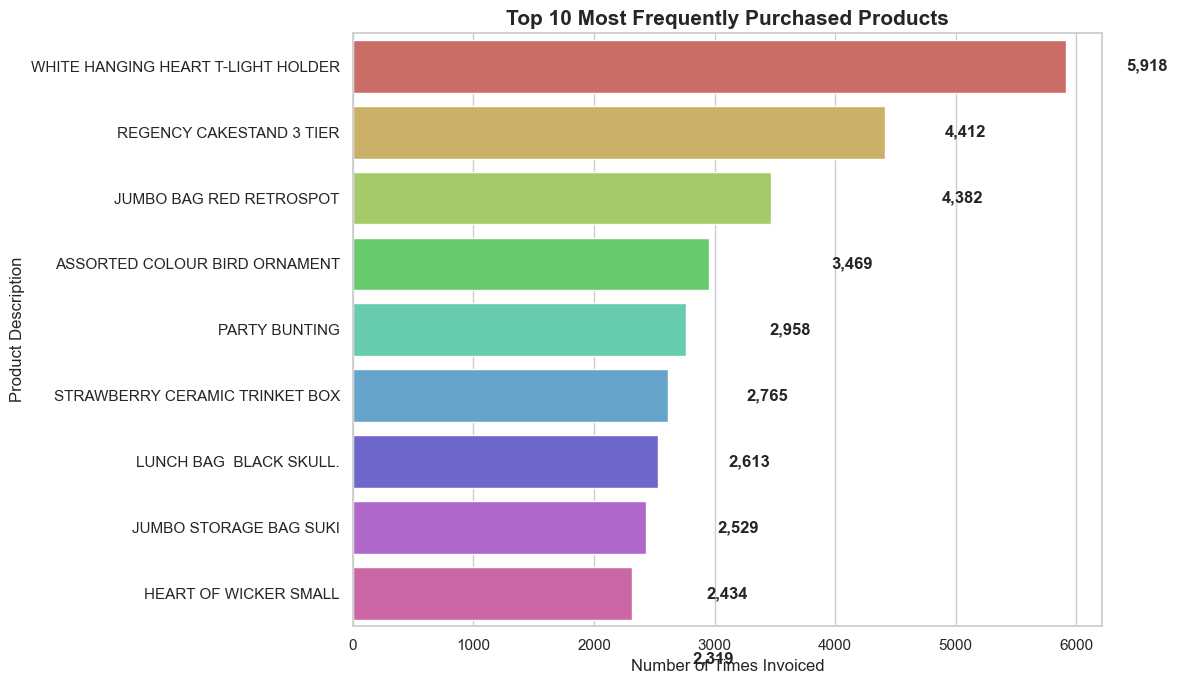

In [31]:
# 1. Prepare Data: Count occurrences of each product description
top_products = raw_df.groupBy("Description").count() \
                     .orderBy("count", ascending=False) \
                     .limit(10).toPandas()

# 2. Plotting
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Using a vibrant 'Set2' or 'hls' palette
ax = sns.barplot(data=top_products, x='count', y='Description', hue='Description', palette='hls', legend=False)

plt.title('Top 10 Most Frequently Purchased Products', fontsize=15, fontweight='bold')
plt.xlabel('Number of Times Invoiced', fontsize=12)
plt.ylabel('Product Description', fontsize=12)

# Adding data labels to the ends of the bars
for i, v in enumerate(top_products['count']):
    ax.text(v + 500, i, f'{v:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Observation:

The analysis identifies high-demand staples like the 'White Hanging Heart T-Light Holder' as the primary inventory drivers, suggesting these 'hero products' are the most effective candidates for promotional bundling and cross-selling strategies.

#### Data Quality Audit

In [32]:
# ==========================================
# PHASE 2.2: COMPREHENSIVE DATA QUALITY AUDIT
# ==========================================
from pyspark.sql import functions as F

# 1. Define Administrative/Non-Product Stock Codes
admin_codes = ["POST", "D", "M", "DOT", "BANK CHARGES", "ADJUST", "TEST", "PADS"]

# 2. Perform Calculations
total_records = raw_df.count()

# Null Counts
null_summary = raw_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in raw_df.columns]).collect()[0]

# Logic & Structural Errors
cancellations = raw_df.filter(F.col("InvoiceNo").startswith("C")).count()
negative_qty_price = raw_df.filter((F.col("Quantity") <= 0) | (F.col("Price") <= 0)).count()
duplicates = raw_df.count() - raw_df.dropDuplicates().count()

# Administrative Code Count
admin_count = raw_df.filter(F.col("StockCode").isin(admin_codes)).count()

# 3. Print the Final Report
print("="*50)
print("🛡️  OFFICIAL DATA QUALITY AUDIT REPORT")
print("="*50)
print(f"📊 Dataset Overview:")
print(f"   - Total Raw Records: {total_records:,}")
print(f"   - Unique Customer IDs: {raw_df.select('CustomerID').distinct().count():,}")

print(f"\n🚫 Identification of Issues:")
print(f"   - Missing CustomerIDs: {null_summary['CustomerID']:,}")
print(f"   - Cancelled Invoices ('C'): {cancellations:,}")
print(f"   - Invalid Qty/Price (≤ 0): {negative_qty_price:,}")
print(f"   - Admin/Service StockCodes: {admin_count:,}")
print(f"   - Exact Duplicate Rows: {duplicates:,}")

print(f"\n🔍 Missing Values (Nulls) per Column:")
print("-" * 30)
for col in raw_df.columns:
    print(f"   - {col:12}: {null_summary[col]:,}")

print("\n" + "="*50)
print("✅ END OF AUDIT")
print("="*50)

🛡️  OFFICIAL DATA QUALITY AUDIT REPORT
📊 Dataset Overview:
   - Total Raw Records: 1,067,371
   - Unique Customer IDs: 5,943

🚫 Identification of Issues:
   - Missing CustomerIDs: 243,007
   - Cancelled Invoices ('C'): 19,494
   - Invalid Qty/Price (≤ 0): 25,700
   - Admin/Service StockCodes: 5,354
   - Exact Duplicate Rows: 34,335

🔍 Missing Values (Nulls) per Column:
------------------------------
   - InvoiceNo   : 0
   - StockCode   : 0
   - Description : 4,382
   - Quantity    : 0
   - InvoiceDate : 0
   - Price       : 0
   - CustomerID  : 243,007
   - Country     : 0

✅ END OF AUDIT


### Data Cleaning

##### Calculating null values from each column.

In [33]:
from pyspark.sql import functions as F

# Calculate null counts for every column
null_counts = raw_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in raw_df.columns])

print("🔍 MISSING DATA SUMMARY (NULL COUNTS)")
null_counts.toPandas()

🔍 MISSING DATA SUMMARY (NULL COUNTS)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,0,0,4382,0,0,0,243007,0


Observation:

Based on the dataset, I notice a high number of missing values in the CustomerID column (approximately 243,007 missing rows).

Justification: I remove these rows because Customer Segmentation (K-Means) and RFM analysis require a unique identifier for each customer.

Impact: Without a CustomerID, I cannot link transactions to a specific person, making that data unusable for consumer behavior insights.

In [34]:
# ==========================================
# PHASE 3: DATA CLEANING 
# ==========================================

# 1. Drop rows where CustomerID is null
cleaned_df = raw_df.dropna(subset=["CustomerID"])

##### Checking for any cancelled orders or orders hving any negative quantity (refunded orders)

In [35]:
from pyspark.sql import functions as F

# Filter for invoices starting with 'C' and check their quantities
cancellation_check = raw_df.filter(F.col("InvoiceNo").startswith("C")) \
                           .select("InvoiceNo", "Quantity", "Description", "Price")

print("🔍 Verification of 'C' Invoices:")
cancellation_check.show(5)

# Check if these invoices generally have negative quantities
negative_q_count = cancellation_check.filter(F.col("Quantity") < 0).count()
print(f"Total 'C' Invoices: {cancellation_check.count()}")
print(f"Number of 'C' Invoices with Negative Quantities: {negative_q_count}")

🔍 Verification of 'C' Invoices:
+---------+--------+--------------------+-----+
|InvoiceNo|Quantity|         Description|Price|
+---------+--------+--------------------+-----+
|  C489449|     -12|PAPER BUNTING WHI...| 2.95|
|  C489449|      -6|CREAM FELT EASTER...| 1.65|
|  C489449|      -4|POTTING SHED SOW ...| 4.25|
|  C489449|      -6|  POTTING SHED TWINE|  2.1|
|  C489449|     -12|PAPER CHAIN KIT R...| 2.95|
+---------+--------+--------------------+-----+
only showing top 5 rows
Total 'C' Invoices: 19494
Number of 'C' Invoices with Negative Quantities: 19493


##### Filtering out non business orders.

In [36]:
# Filter out non-business data
# We remove 'C' invoices (cancellations) and ensure Price/Quantity > 0
cleaned_df = cleaned_df.filter(~F.col("InvoiceNo").startswith("C")) \
                       .filter((F.col("Quantity") > 0) & (F.col("Price") > 0))

# 3. Verify the "Cleaned" count for your report
print(f"✅ Original Rows: {raw_df.count():,}")
print(f"✅ Cleaned Rows:  {cleaned_df.count():,}")

✅ Original Rows: 1,067,371
✅ Cleaned Rows:  805,549


Purpose: The project goal is to analyze Consumer Behavior and Revenue.

Logic: Including cancellations would artificially lower the "Monetary" value in your RFM analysis and skew the "Frequency" of actual purchases.

Action: Therefore, I filter them out to ensure the Machine Learning models only learn from successful, completed transactions.

##### Checking for Duplicate Rows and cleaning it

In [37]:
# Check for Duplicate Rows
duplicate_count = cleaned_df.count() - cleaned_df.dropDuplicates().count()
print(f"👯 Duplicate Rows Found:           {duplicate_count}")

👯 Duplicate Rows Found:           26124


In [38]:
# Remove the 26,124 duplicates found in the audit
cleaned_df = cleaned_df.dropDuplicates()

print(f"✅ Final Cleaned Record Count: {cleaned_df.count():,}")

✅ Final Cleaned Record Count: 779,425


#### Checking for stock codes that don't look like products

In [39]:
# Filter for StockCodes that are NOT the standard 5-6 character alphanumeric pattern
# We look for codes that are purely alphabetical or contain special words
anomalous_codes = cleaned_df.filter(F.col("StockCode").rlike("^[a-zA-Z]+$")) \
                            .select("StockCode", "Description") \
                            .distinct()

print("🔍 NON-PRODUCT STOCK CODES IDENTIFIED:")
anomalous_codes.show()

🔍 NON-PRODUCT STOCK CODES IDENTIFIED:
+---------+--------------------+
|StockCode|         Description|
+---------+--------------------+
|     POST|             POSTAGE|
|        M|              Manual|
|   ADJUST|Adjustment by joh...|
|     PADS|PADS TO MATCH ALL...|
|   ADJUST|Adjustment by joh...|
|        D|            Discount|
|      DOT|      DOTCOM POSTAGE|
+---------+--------------------+



Observation:

Administrative Stock Codes:

 I identified several stock codes such as 'POST', 'D', and 'M' that do not represent physical products. These entries refer to postage fees, discounts, and manual adjustments. For the purpose of Market Basket Analysis and Product Association, these records must be filtered out as they do not reflect actual consumer purchasing patterns.

In [40]:
# Cleaning step to remove the non-product codes
non_product_codes = ["POST", "D", "M", "DOT", "BANK CHARGES", "ADJUST", "TEST"]
cleaned_df = cleaned_df.filter(~F.col("StockCode").isin(non_product_codes))

print(f"✅ Final Cleaned Count after removing non-products: {cleaned_df.count():,}")

✅ Final Cleaned Count after removing non-products: 776,857


### Data Quality Audit Report

In [43]:
# ==========================================
# PHASE 3.2: DATA QUALITY VERIFICATION
# ==========================================
from pyspark.sql import functions as F

# 1. Define the same criteria used in Phase 2.2 for consistency
admin_codes = ["POST", "D", "M", "DOT", "BANK CHARGES", "ADJUST", "TEST", "PADS"]

# 2. Perform Verification Calculations on cleaned_df
final_count = cleaned_df.count()
final_nulls = cleaned_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in cleaned_df.columns]).collect()[0]
final_cancellations = cleaned_df.filter(F.col("InvoiceNo").startswith("C")).count()
final_negatives = cleaned_df.filter((F.col("Quantity") <= 0) | (F.col("Price") <= 0)).count()
final_duplicates = cleaned_df.count() - cleaned_df.dropDuplicates().count()
final_admin_count = cleaned_df.filter(F.col("StockCode").isin(admin_codes)).count()

# 3. Print the Verification Report
print("="*50)
print("✅ POST-CLEANING VERIFICATION REPORT")
print("="*50)
print(f"📊 Final Dataset Dimensions:")
print(f"   - Total Cleaned Records: {final_count:,}")
print(f"   - Total Customers Retained: {cleaned_df.select('CustomerID').distinct().count():,}")

print(f"\n🛡️  Integrity Checks (Should all be 0):")
print(f"   - Missing CustomerIDs:      {final_nulls['CustomerID']} {'✅' if final_nulls['CustomerID'] == 0 else '❌'}")
print(f"   - Cancelled Invoices ('C'): {final_cancellations} {'✅' if final_cancellations == 0 else '❌'}")
print(f"   - Invalid Qty/Price (≤ 0):  {final_negatives} {'✅' if final_negatives == 0 else '❌'}")
print(f"   - Admin/Service StockCodes: {final_admin_count} {'✅' if final_admin_count == 0 else '❌'}")
print(f"   - Exact Duplicate Rows:     {final_duplicates} {'✅' if final_duplicates == 0 else '❌'}")

print(f"\n🔍 Final Null Check (Across All Columns):")
print("-" * 30)
for col in cleaned_df.columns:
    print(f"   - {col:12}: {final_nulls[col]} {'✅' if final_nulls[col] == 0 else '❌'}")

print("\n" + "="*50)
print("🌟 DATA IS READY FOR RFM & MODELING")
print("="*50)

✅ POST-CLEANING VERIFICATION REPORT
📊 Final Dataset Dimensions:
   - Total Cleaned Records: 776,840
   - Total Customers Retained: 5,853

🛡️  Integrity Checks (Should all be 0):
   - Missing CustomerIDs:      0 ✅
   - Cancelled Invoices ('C'): 0 ✅
   - Invalid Qty/Price (≤ 0):  0 ✅
   - Admin/Service StockCodes: 0 ✅
   - Exact Duplicate Rows:     0 ✅

🔍 Final Null Check (Across All Columns):
------------------------------
   - InvoiceNo   : 0 ✅
   - StockCode   : 0 ✅
   - Description : 0 ✅
   - Quantity    : 0 ✅
   - InvoiceDate : 0 ✅
   - Price       : 0 ✅
   - CustomerID  : 0 ✅
   - Country     : 0 ✅

🌟 DATA IS READY FOR RFM & MODELING


In [44]:
# --- FINAL CLEANING BASED ON AUDIT ---


admin_codes = ["POST", "D", "M", "DOT", "BANK CHARGES", "ADJUST", "TEST", "PADS"]

# Apply all audit-based filters
cleaned_df = raw_df.dropna(subset=["CustomerID"]) \
    .filter(~F.col("InvoiceNo").startswith("C")) \
    .filter((F.col("Quantity") > 0) & (F.col("Price") > 0)) \
    .filter(~F.col("StockCode").isin(admin_codes)) \
    .dropDuplicates()

print(f"✅ CLEANING COMPLETE")
print(f"Final usable records: {cleaned_df.count():,}")

✅ CLEANING COMPLETE
Final usable records: 776,840
